In [1]:
from scipy.special import linestyle

import sr_signal
import database
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import product
import pickle
import os

# This is for jupyter to recognize changes in external files without restarting kernel
%load_ext autoreload
%autoreload 2

# Inputs

In [2]:
# Simulation data
path = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output"
scenarios = ["S7_IRREG1_K1", "S8_IRREG1_K0d7", "S9_IRREG1_K0d5", "S10_IRREG1_K1d35", "S11_IRREG2_K1"]
sensor_locations = ["SRS_CB_B1", "SRS_CB_cab", "SRS_B1_R", "SRS_B1_WS1_R"]
sensor_names = ["carbody_B1", "carbody_cab", "B1_right", "WS1_right"]

fs = 50  # Hz

# segmentation
seg_len_sec = 16.0
seg_hop_sec = 1.6  # 90% overlap
seg_len_samples = int(seg_len_sec * fs)  # 800
seg_hop_samples = int(seg_hop_sec * fs)  # 80

# Load data

In [3]:
scenario_data = {}

for scenario in scenarios:
    scenario_data[scenario] = sr_signal.load_data(path, scenario)

# Build database -- 1 min

In [4]:
train_db = database.FingerprintDatabase()
test_segments  = []
fingerprints_per_segment = {}
raw_signals_by_segment = {}

for scenario in scenarios:
    for sensor_name in sensor_names:
        acceleration, time, dist = scenario_data[scenario][sensor_name]

        segments = []  # list of (seg_signal, seg_start_time, seg_index) tuples

        N = len(acceleration)
        seg_index = 0
        start = 0
        while start + seg_len_samples <= N:
            end = start + seg_len_samples
            seg_signal = acceleration[start:end]
            seg_start_time = time[start]  # absolute time from simulation start
            segments.append((seg_signal, seg_start_time, seg_index))
            seg_index += 1
            start += seg_hop_samples

        for seg_signal, seg_start_time, seg_idx in segments:

            stft_magnitude, peaks, frame_times, freqs = sr_signal.process_signal(seg_signal)
            abs_frame_times = frame_times + seg_start_time

            fingerprints = sr_signal.gen_fingerprints_from_peaks(peaks)
            fingerprints_per_segment[(scenario, sensor_name, seg_idx)] = fingerprints
            raw_signals_by_segment[(scenario, sensor_name, seg_idx)] = (seg_signal, seg_start_time)

            # add to database

            if seg_idx % 2 == 0:

                train_db.add_fingerprints_batch(
                    fingerprints,
                    scenario_name=scenario,
                    segment_index=seg_idx,
                    sensor_name=sensor_name,
                    frame_time_sec=seg_start_time,  # segment start is enough
                )
            else:
                test_segments.append((scenario, sensor_name, seg_idx))

stats = train_db.get_statistics()
print(f"\nTrain database statistics:")
print(f"  Scenarios: {stats['num_scenarios']}")
print(f"  Sensors: {stats['num_sensors']}")
print(f"  Unique hashes: {stats['unique_hashes']}")
print(f"  Total entries: {stats['total_entries']}")
print(f"  Avg entries per hash: {stats['avg_entries_per_hash']:.2f}")




Train database statistics:
  Scenarios: 5
  Sensors: 4
  Unique hashes: 4046
  Total entries: 2128500
  Avg entries per hash: 526.08


# Query for matching

In [21]:
# Take a random sample of 16 seconds and generate fingerprints to match against database

scenario = random.choice(list(scenario_data.keys()))
sensor_name = sensor_names[1]
acceleration, time, dist = scenario_data[scenario][sensor_name]

start_idx = random.randint(0, len(acceleration) - seg_len_samples)
end_idx = start_idx + seg_len_samples

acc_snippet = acceleration[start_idx:end_idx]

print(f'Random scenario: {scenario}')
print(f'Random sensor: {sensor_name}')
print(f'Random segment: {start_idx // seg_hop_samples}')

fingerprints = sr_signal.compute_fingerprints_for_segments(acc_snippet)

print(f"Sample has {len(fingerprints)} unique fingerprints")
# values = list(fingerprints.values())
# print(values[0])

Random scenario: S9_IRREG1_K0d5
Random sensor: carbody_cab
Random segment: 63
Sample has 339 unique fingerprints


# Match scoring design

3 options:
   - Plain hash count
   - Unique hash score
   - Shazam-like offset-consistency score

In [5]:
def flatten_db_for_sensor(db, sensor_name):
    """
    Convert db[sensor_name][hash_tuple] -> list of entries into a flat structure:
    - hash_to_entries: {hash_tuple -> [(scenario, segment_index, anchor_time, frame_time), ...]}
    - scenarios: sorted list of scenario names
    """
    sensor_db = db[sensor_name]
    hash_to_entries = {}
    scenarios_set = set()

    for h, entries in sensor_db.items():
        clean_entries = []
        for scenario_name, segment_index, sensor_name, anchor_time_sec, frame_time_sec in entries:
            clean_entries.append((scenario_name, segment_index, anchor_time_sec, frame_time_sec))
            scenarios_set.add(scenario_name)
        hash_to_entries[h] = clean_entries

    scenarios = sorted(scenarios_set)
    return hash_to_entries, scenarios

In [6]:
def match_plain_hash_count(sample_fps, hash_to_entries):
    """
    Counter {scenario_name -> score}
    """
    scores = Counter()

    for h, sample_times in sample_fps.items():
        if h not in hash_to_entries:
            continue
        db_entries = hash_to_entries[h]
        # Each sample occurrence matched with each DB occurrence contributes 1
        for scenario_name, seg_idx, anchor_time_db, frame_time_db in db_entries:
            scores[scenario_name] += len(sample_times)

    return scores

In [7]:
def match_unique_hashes(sample_fps, hash_to_entries):
    """
    Score by number of distinct hash keys shared with each scenario.
    """
    scenario_hashes = defaultdict(set)

    for h in sample_fps.keys():
        if h not in hash_to_entries:
            continue
        for scenario_name, seg_idx, anchor_time_db, frame_time_db in hash_to_entries[h]:
            scenario_hashes[scenario_name].add(h)

    scores = {sc: len(hashes) for sc, hashes in scenario_hashes.items()}
    return scores

In [8]:
def match_offset_consistency(sample_fps, hash_to_entries, offset_bin_sec=0.2, min_votes=3):
    """
    For each scenario, build a histogram of time offsets:
      offset = anchor_time_db - anchor_time_sample
    Score = max histogram count for that scenario (dominant offset bin).
    """
    scenario_offset_votes = defaultdict(list)  # {scenario -> [offsets]}

    for h, sample_times in sample_fps.items():
        if h not in hash_to_entries:
            continue

        db_entries = hash_to_entries[h]
        for scenario_name, seg_idx, anchor_time_db, frame_time_db in db_entries:
            for t_sample in sample_times:
                offset = anchor_time_db - t_sample
                scenario_offset_votes[scenario_name].append(offset)

    scenario_scores = {}
    scenario_offset_hist = {}

    for scenario_name, offsets in scenario_offset_votes.items():
        if not offsets:
            continue
        offsets = np.array(offsets)
        # Bin offsets
        bins = np.arange(offsets.min() - offset_bin_sec, offsets.max() + 2*offset_bin_sec, offset_bin_sec)
        hist, bin_edges = np.histogram(offsets, bins=bins)
        max_count = hist.max()
        scenario_scores[scenario_name] = max_count
        scenario_offset_hist[scenario_name] = (hist, bin_edges)

    # Optionally filter out very weak scenarios
    scenario_scores = {sc: s for sc, s in scenario_scores.items() if s >= min_votes}

    return scenario_scores, scenario_offset_hist

# Experiments

In [59]:
sensor_name = sensor_names[3]

hash_to_entries, scenario_list = flatten_db_for_sensor(train_db.db, sensor_name)

print(list(hash_to_entries.keys())[0])

(np.int64(10), np.int64(10), np.int64(4))


## 1. Condition separability -- 13-18 minutes

In [9]:
def map_scenario(sc):
    if sc in ("S8_IRREG1_K0d7", "S9_IRREG1_K0d5", "S10_IRREG1_K1d35"):
        return "Stiffness change"
    elif sc == "S7_IRREG1_K1":
        return "Baseline"
    elif sc == "S11_IRREG2_K1":
        return "Track change"

In [10]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_1.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_sep = data["confusion_dict"]
    accuracy_dict_sep = data["accuracy_dict"]

else:
    print("Generating results...")

    confusion_dict_sep = {}
    accuracy_dict_sep = {}
    for matcher in ("plain", "unique", "offset"):
        confusion_dict_sep[matcher] = {}
        accuracy_dict_sep[matcher] = {}
        for sensor_name in sensor_names:

            hash_to_entries, scenario_list = flatten_db_for_sensor(train_db.db, sensor_name)
            grouped_scenarios = ["Baseline", "Stiffness change", "Track change"]
            scenario_to_idx = {sc: i for i, sc in enumerate(grouped_scenarios)}
            S = len(grouped_scenarios)
            confusion = np.zeros((S, S), dtype=int)

            for true_scenario, sensor, seg_idx in test_segments:
                if sensor != sensor_name:
                    continue
                sample_fps = fingerprints_per_segment[(true_scenario, sensor, seg_idx)]

                if matcher == "plain":
                    scores = match_plain_hash_count(sample_fps, hash_to_entries)
                elif matcher == "unique":
                    scores = match_unique_hashes(sample_fps, hash_to_entries)
                elif matcher == "offset":
                    scores, _ = match_offset_consistency(sample_fps, hash_to_entries)
                else:
                    raise ValueError("Unknown matcher")

                if not scores:
                    continue  # no match, treat as miss (optional: count separately)

                # Predict scenario with max score
                predicted_scenario = max(scores.items(), key=lambda x: x[1])[0]

                true_group = map_scenario(true_scenario)
                pred_group = map_scenario(predicted_scenario)

                i = scenario_to_idx[true_group]
                j = scenario_to_idx[pred_group]
                confusion[i, j] += 1

            total = confusion.sum()
            correct = np.trace(confusion)
            accuracy = correct / total if total > 0 else 0.0

            confusion_dict_sep[matcher][sensor_name] = confusion
            accuracy_dict_sep[matcher][sensor_name] = accuracy

            with open(filename, "wb") as f:
                pickle.dump({
                    "confusion_dict": confusion_dict_sep,
                    "accuracy_dict": accuracy_dict_sep
                }, f)

Loading cached results...


In [11]:
def conf_mat_sep(sensor_name, confusion_dict):
    matchers = list(confusion_dict.keys())[:3]
    grouped_labels = ["Baseline", "Stiffness change", "Track change"]   # grouped scenarios

    fig, axes = plt.subplots(1, 3, figsize=(11, 5))

    for idx, (ax, matcher) in enumerate(zip(axes, matchers)):
        confusion = confusion_dict[matcher][sensor_name]
        im = ax.imshow(confusion, cmap="Blues")

        S = confusion.shape[0]

        # annotate cells
        for i in range(S):
            for j in range(S):
                val = confusion[i, j]
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", color="black")

        # x-axis
        ax.set_xticks(range(S))
        ax.set_xticklabels(grouped_labels, rotation=45, ha="right")
        ax.set_xlabel("Predicted scenario")
        ax.set_title(matcher)

        # y-axis
        ax.set_yticks(range(S))
        if idx == 0:
            ax.set_yticklabels(grouped_labels)
            ax.set_ylabel("True scenario")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    fig.suptitle(f"Condition separability with {sensor_name}", fontsize=16)

    # plt.tight_layout()
    plt.show()

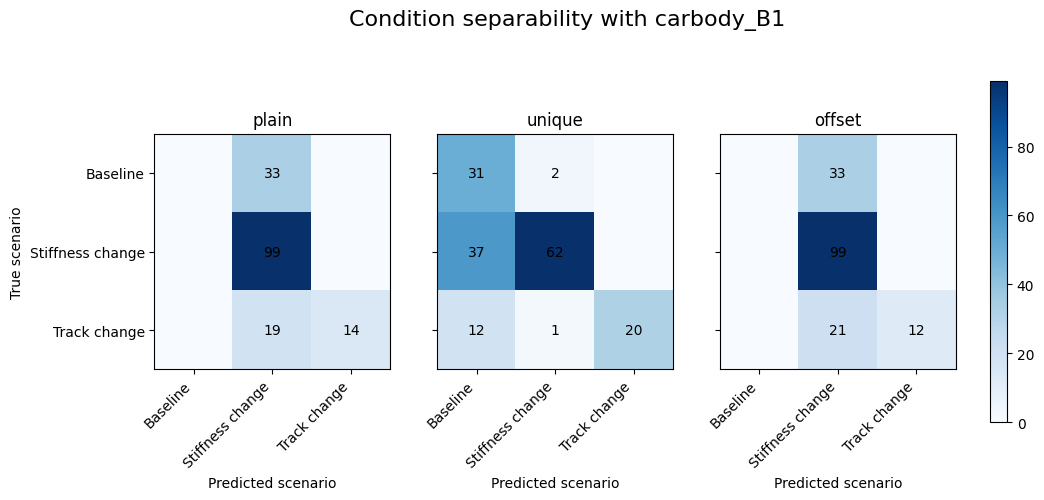

In [12]:
conf_mat_sep(sensor_names[0], confusion_dict_sep)

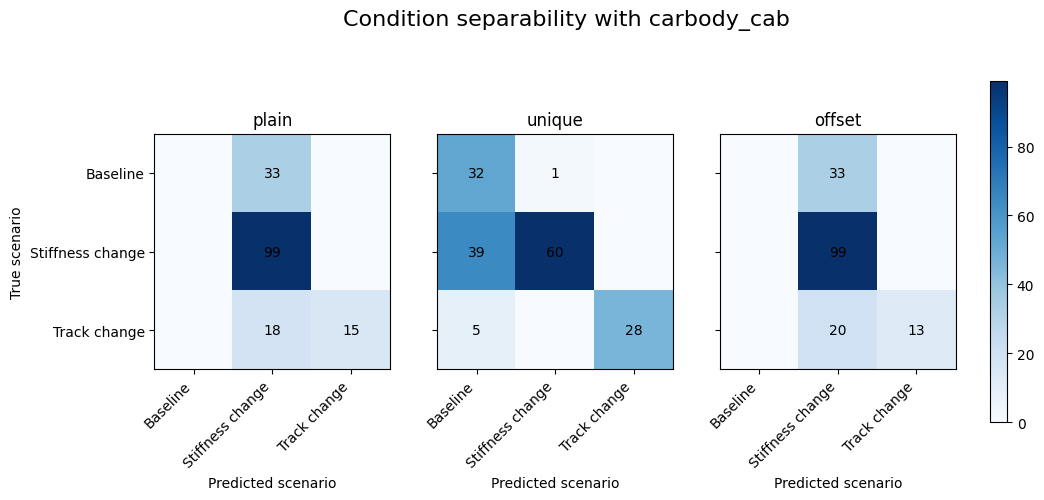

In [13]:
conf_mat_sep(sensor_names[1], confusion_dict_sep)

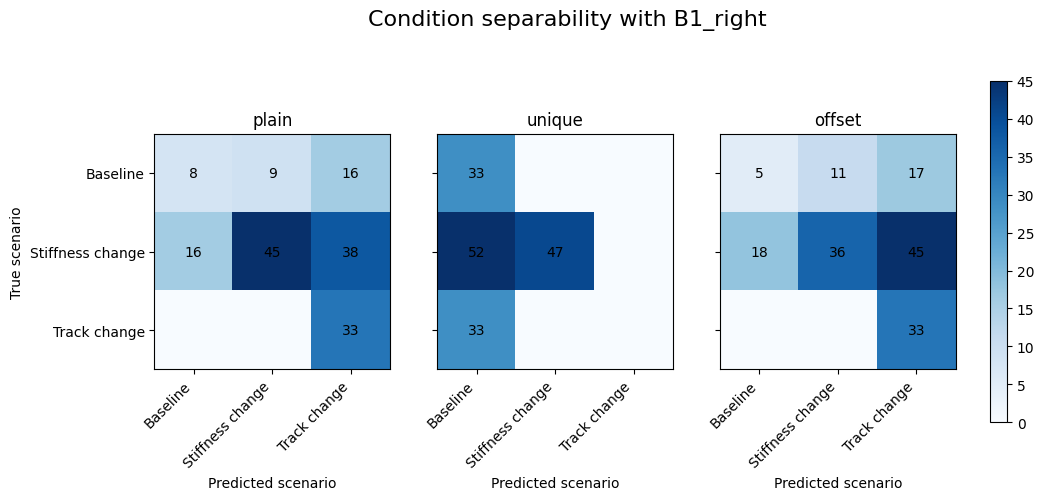

In [14]:
conf_mat_sep(sensor_names[2], confusion_dict_sep)

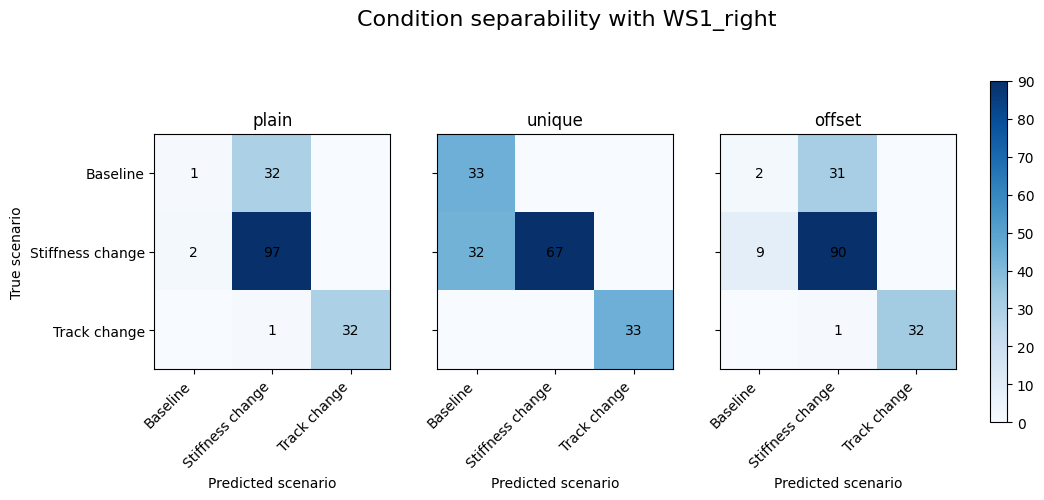

In [15]:
conf_mat_sep(sensor_names[3], confusion_dict_sep)

# 2. Sensitivity to gradual change

In [16]:
def map_scenario_grad(sc):
    if sc == "S7_IRREG1_K1":
        return "Baseline"
    elif sc == "S8_IRREG1_K0d7":
        return "Aging rubber spring"
    elif sc == "S9_IRREG1_K0d5":
        return "Degraded rubber spring"
    elif sc == "S10_IRREG1_K1d35":
        return "Broken coil spring"
    elif sc == "S11_IRREG2_K1":
        return "Worse track quality"

In [17]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_2.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_grad = data["confusion_dict"]
    accuracy_dict_grad = data["accuracy_dict"]

else:
    print("Generating results...")

    confusion_dict_grad = {}
    accuracy_dict_grad = {}
    for matcher in ("plain", "unique", "offset"):
        confusion_dict_grad[matcher] = {}
        accuracy_dict_grad[matcher] = {}
        for sensor_name in sensor_names:

            hash_to_entries, scenario_list = flatten_db_for_sensor(train_db.db, sensor_name)
            grouped_scenarios = ["Baseline", "Aging rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]
            scenario_to_idx = {sc: i for i, sc in enumerate(grouped_scenarios)}
            S = len(grouped_scenarios)
            confusion = np.zeros((S, S), dtype=int)

            for true_scenario, sensor, seg_idx in test_segments:
                if sensor != sensor_name:
                    continue
                sample_fps = fingerprints_per_segment[(true_scenario, sensor, seg_idx)]

                if matcher == "plain":
                    scores = match_plain_hash_count(sample_fps, hash_to_entries)
                elif matcher == "unique":
                    scores = match_unique_hashes(sample_fps, hash_to_entries)
                elif matcher == "offset":
                    scores, _ = match_offset_consistency(sample_fps, hash_to_entries)
                else:
                    raise ValueError("Unknown matcher")

                if not scores:
                    continue  # no match, treat as miss (optional: count separately)

                # Predict scenario with max score
                predicted_scenario = max(scores.items(), key=lambda x: x[1])[0]

                true_group = map_scenario_grad(true_scenario)
                pred_group = map_scenario_grad(predicted_scenario)

                i = scenario_to_idx[true_group]
                j = scenario_to_idx[pred_group]
                confusion[i, j] += 1

            total = confusion.sum()
            correct = np.trace(confusion)
            accuracy = correct / total if total > 0 else 0.0

            confusion_dict_grad[matcher][sensor_name] = confusion
            accuracy_dict_grad[matcher][sensor_name] = accuracy

            with open(filename, "wb") as f:
                pickle.dump({
                    "confusion_dict": confusion_dict_grad,
                    "accuracy_dict": accuracy_dict_grad
                }, f)

Loading cached results...


In [22]:
def conf_mat_grad(sensor_name, confusion_dict):
    matchers = list(confusion_dict.keys())[:3]
    grouped_labels = ["Baseline", "Aging rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (ax, matcher) in enumerate(zip(axes, matchers)):
        confusion = confusion_dict[matcher][sensor_name]
        im = ax.imshow(confusion, cmap="Blues")

        S = confusion.shape[0]

        # annotate cells
        for i in range(S):
            for j in range(S):
                val = confusion[i, j]
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", color="black")

        # x-axis
        ax.set_xticks(range(S))
        ax.set_xticklabels(grouped_labels, rotation=45, ha="right")
        ax.set_xlabel("Predicted scenario")
        ax.set_title(matcher)

        # y-axis
        ax.set_yticks(range(S))
        if idx == 0:
            ax.set_yticklabels(grouped_labels)
            ax.set_ylabel("True scenario")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    fig.suptitle(f"Sensitivity to the severity of change with sensor: {sensor_name}", fontsize=16)

    # plt.tight_layout()
    plt.show()

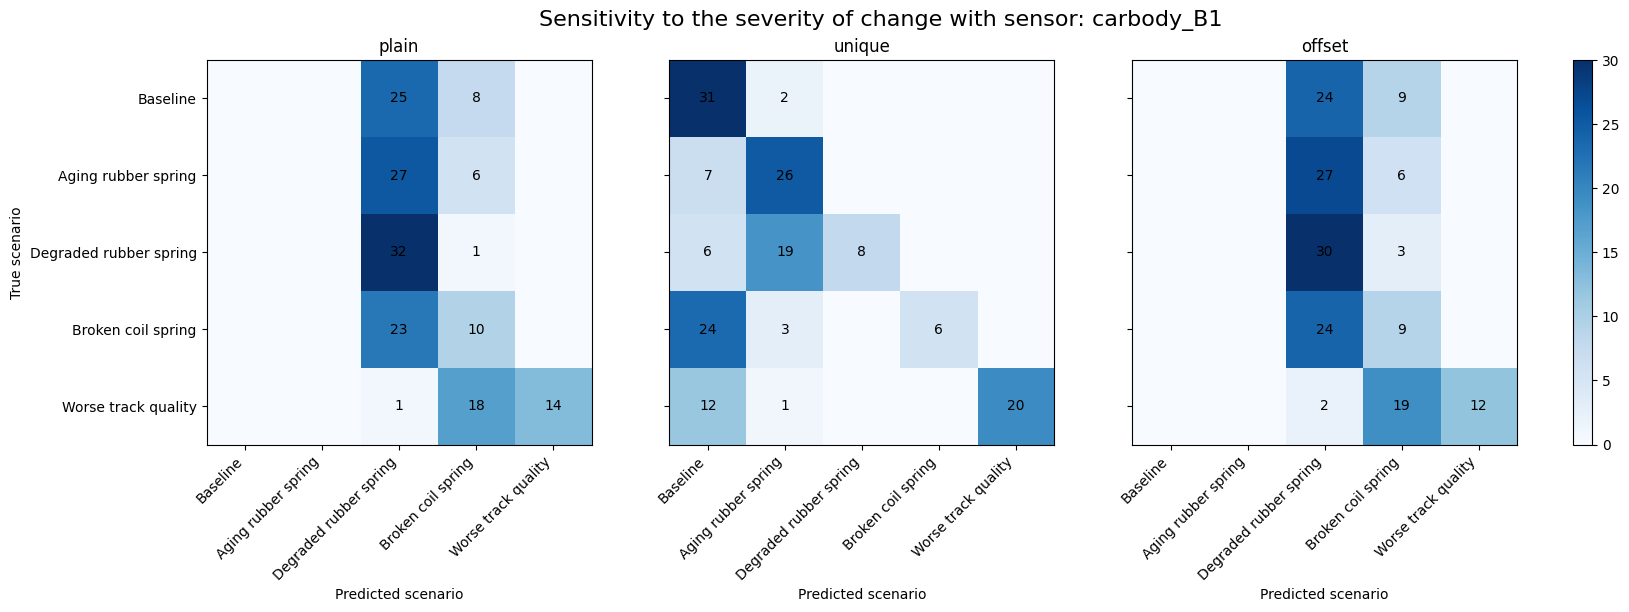

In [23]:
conf_mat_grad(sensor_names[0], confusion_dict_grad)

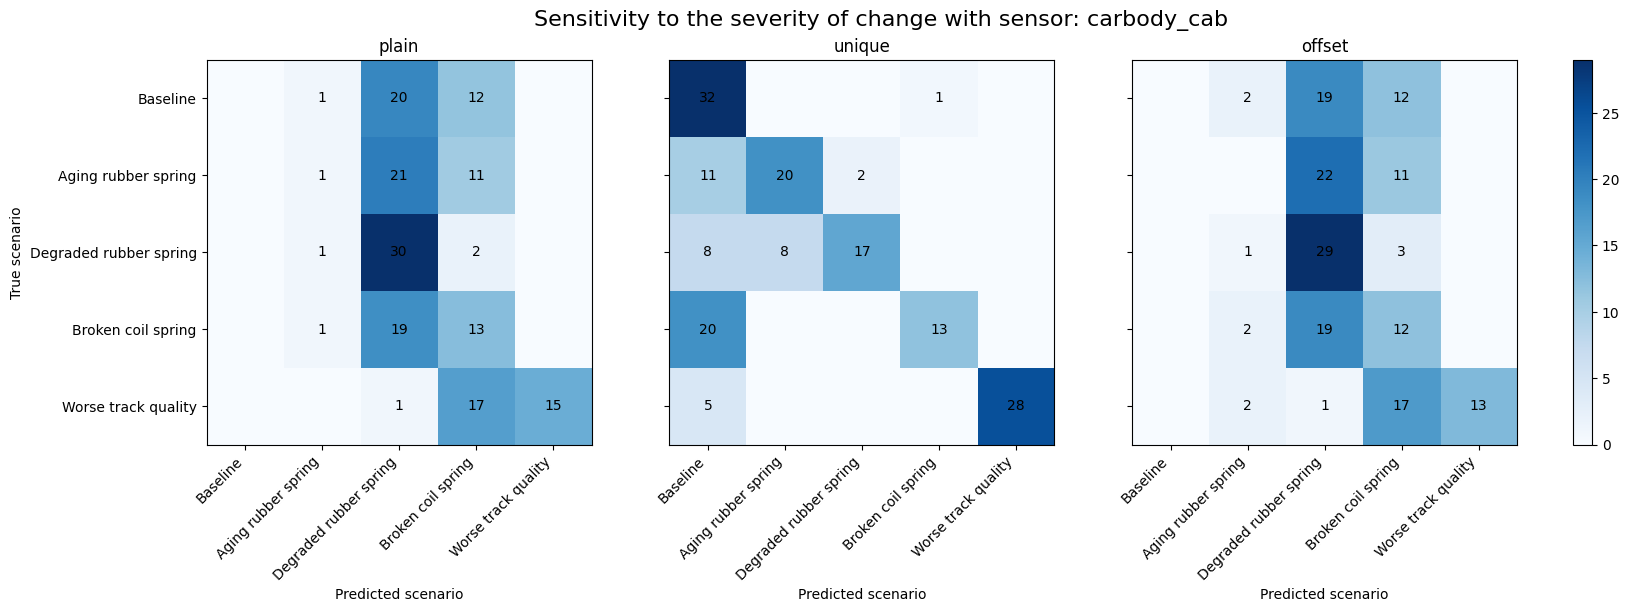

In [24]:
conf_mat_grad(sensor_names[1], confusion_dict_grad)

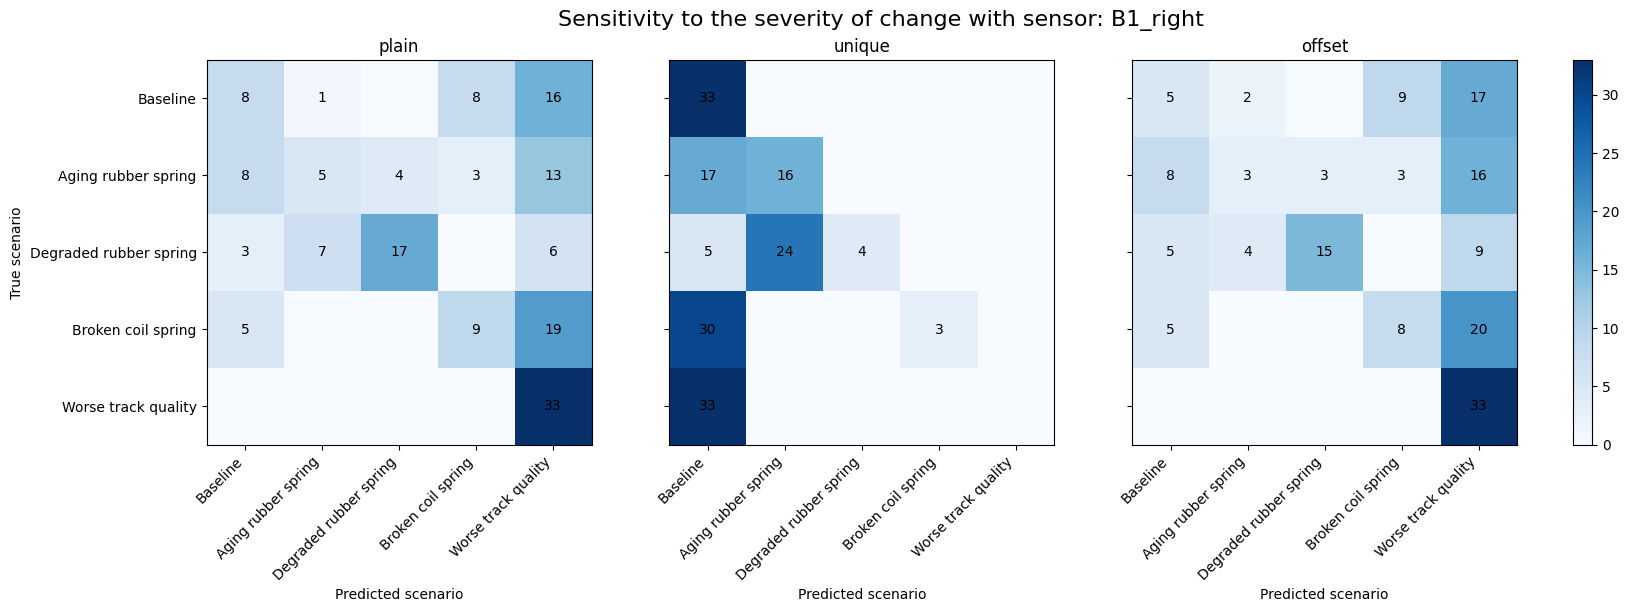

In [25]:
conf_mat_grad(sensor_names[2], confusion_dict_grad)

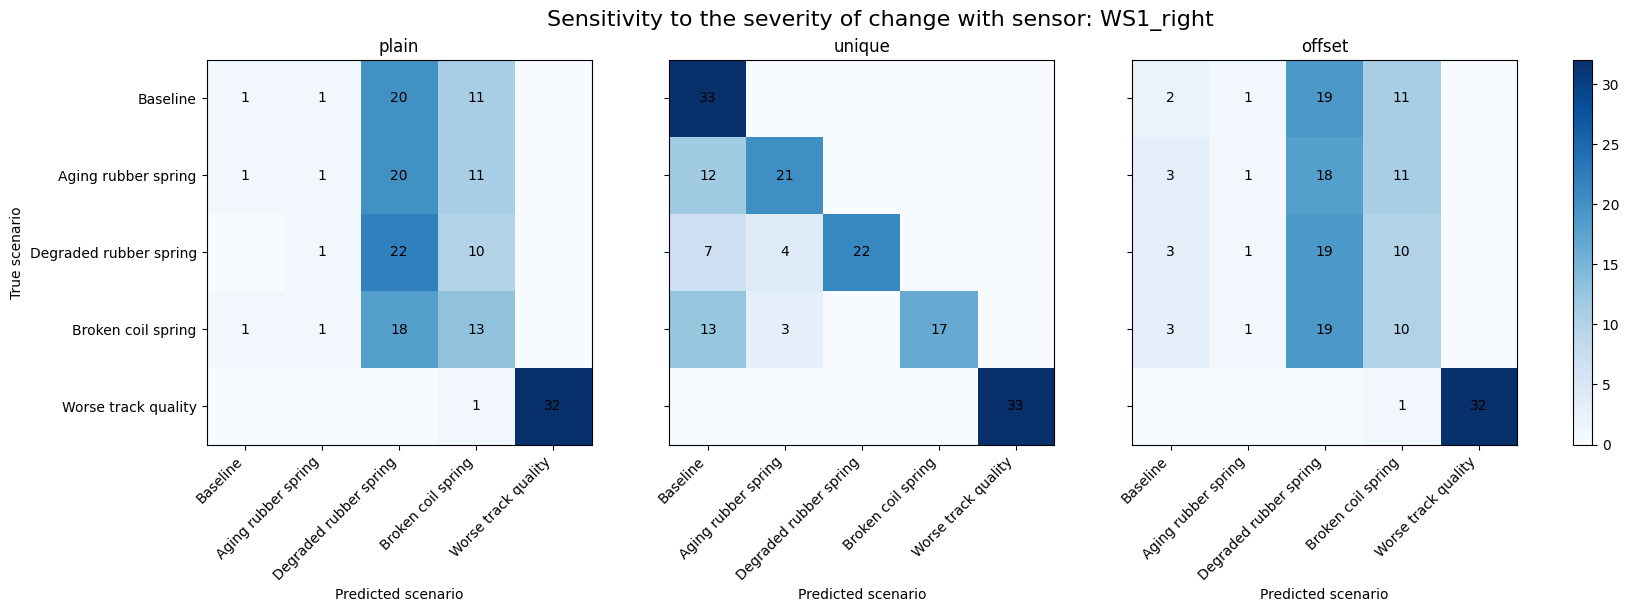

In [26]:
conf_mat_grad(sensor_names[3], confusion_dict_grad)

## 3. Robustness to noise


In [27]:
def add_white_noise(signal, snr_db, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    signal_mean = signal - np.mean(signal)
    sig_power = np.mean(signal_mean**2)
    noise_power = sig_power / (10**(snr_db / 10.0))
    noise = rng.normal(scale=np.sqrt(noise_power), size=signal.shape)
    return signal + noise

In [28]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_3.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_noise = data["confusion_dict"]
    accuracy_dict_noise = data["accuracy_dict"]

else:
    print("Generating results...")

    snr_values = [40, 30, 20, 10, 0]

    confusion_dict_noise = {}
    accuracy_dict_noise = {}
    for matcher in ("plain", "unique", "offset"):
        confusion_dict_noise[matcher] = {}
        accuracy_dict_noise[matcher] = {}
        for sensor_name in sensor_names:
            hash_to_entries, scenario_list = flatten_db_for_sensor(train_db.db, sensor_name)
            grouped_scenarios = ["Baseline", "Aging rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]
            scenario_to_idx = {sc: i for i, sc in enumerate(grouped_scenarios)}
            S = len(grouped_scenarios)
            confusion = np.zeros((S, S), dtype=int)

            confusion_dict_noise[matcher][sensor_name] = {}
            accuracy_dict_noise[matcher][sensor_name] = {}


            for snr_db in snr_values:
                confusion = np.zeros((S, S), dtype=int)

                for true_scenario, sensor, seg_idx in test_segments:
                    if sensor != sensor_name:
                        continue

                    seg_signal, seg_start_time = raw_signals_by_segment[(true_scenario, sensor, seg_idx)]
                    noisy_seg = add_white_noise(seg_signal, snr_db)

                    # Re-run your processing chain here:
                    sample_fps = sr_signal.compute_fingerprints_for_segments(noisy_seg)

                    # Match
                    if matcher == "plain":
                        scores = match_plain_hash_count(sample_fps, hash_to_entries)
                    elif matcher == "unique":
                        scores = match_unique_hashes(sample_fps, hash_to_entries)
                    elif matcher == "offset":
                        scores, _ = match_offset_consistency(sample_fps, hash_to_entries)
                    else:
                        raise ValueError("Unknown matcher")

                    if not scores:
                        continue  # treat as miss (optional: could also increment a separate "no match" counter)

                    predicted_scenario = max(scores.items(), key=lambda x: x[1])[0]

                    true_group = map_scenario_grad(true_scenario)
                    pred_group = map_scenario_grad(predicted_scenario)

                    i = scenario_to_idx[true_group]
                    j = scenario_to_idx[pred_group]
                    confusion[i, j] += 1

                total = confusion.sum()
                correct = np.trace(confusion)
                accuracy = correct / total if total > 0 else 0.0

                confusion_dict_noise[matcher][sensor_name][snr_db] = confusion
                accuracy_dict_noise[matcher][sensor_name][snr_db] = accuracy

                with open(filename, "wb") as f:
                    pickle.dump({
                        "confusion_dict": confusion_dict_noise,
                        "accuracy_dict": accuracy_dict_noise
                    }, f)

Loading cached results...


found


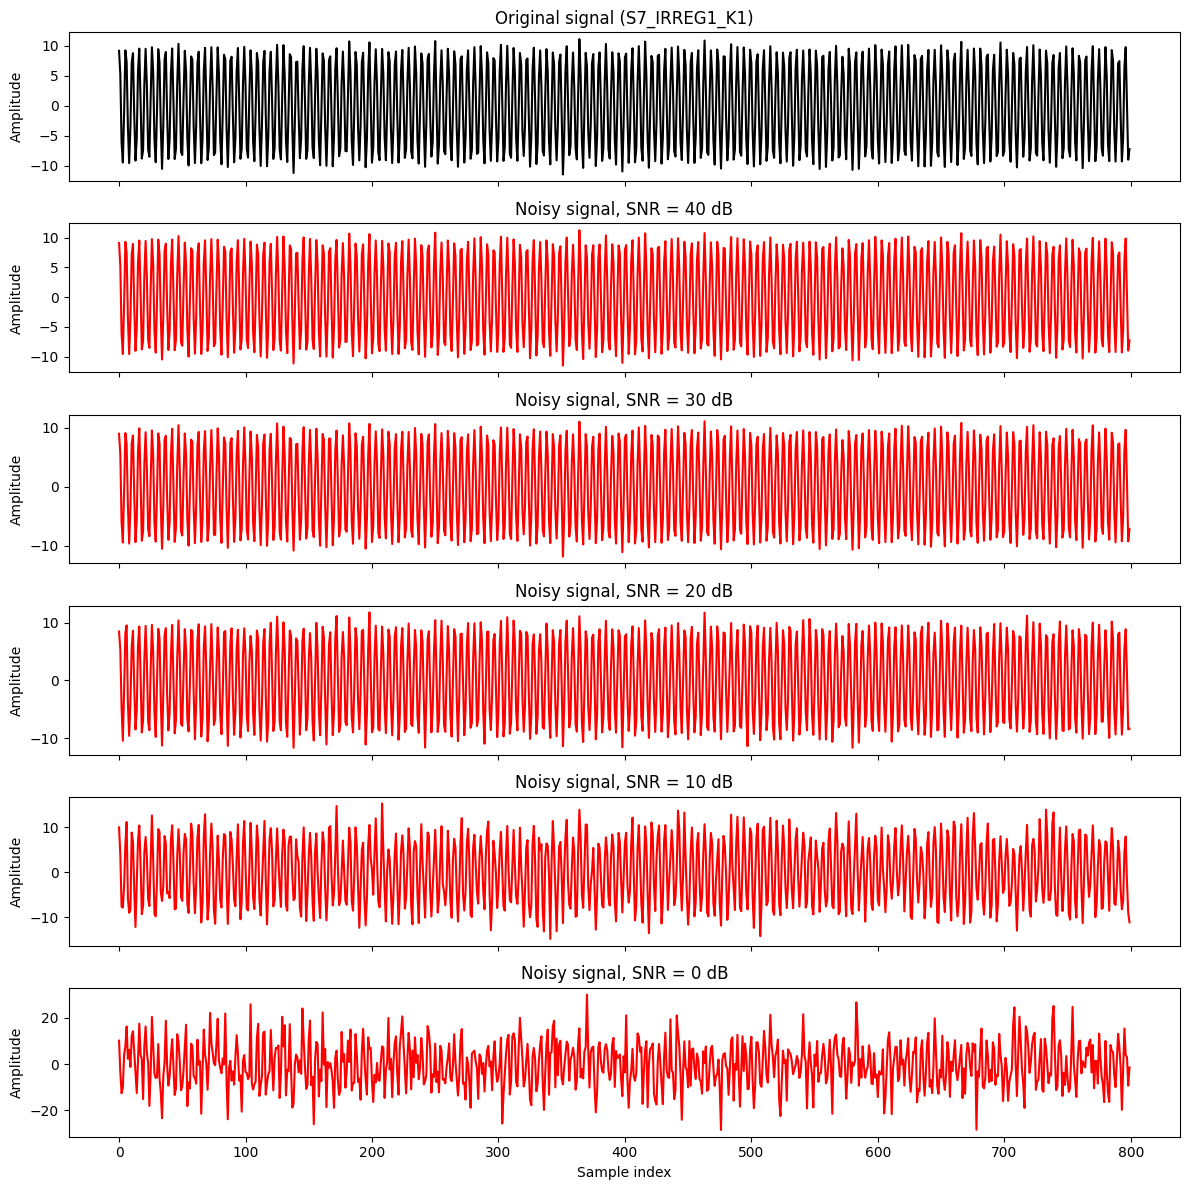

In [110]:
snr_values = [40, 30, 20, 10, 0]
for true_scenario, sensor, seg_idx in test_segments:
    if sensor == sensor_name:
        print("found")
        seg_signal, seg_start_time = raw_signals_by_segment[(true_scenario, sensor, seg_idx)]
        break  # only use the first segment

fig, axes = plt.subplots(len(snr_values)+1, 1, figsize=(12, 2*(len(snr_values)+1)), sharex=True)

# Plot the original signal on top
axes[0].plot(seg_signal, color="black")
axes[0].set_title(f"Original signal ({true_scenario})")
axes[0].set_ylabel("Amplitude")

# Plot noisy signals for each SNR
for idx, snr_db in enumerate(snr_values):
    noisy_seg = add_white_noise(seg_signal, snr_db)
    axes[idx+1].plot(noisy_seg, color="red")
    axes[idx+1].set_title(f"Noisy signal, SNR = {snr_db} dB")
    axes[idx+1].set_ylabel("Amplitude")

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()

In [87]:
def conf_mat_noise(sensor_name, confusion_dict):
    matcher = "unique"
    snr_values = list(next(iter(next(iter(confusion_dict_noise.values())).values())).keys())[:4]
    grouped_labels = ["Baseline", "Aging rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]

    fig, axes = plt.subplots(1, 5, figsize=(28, 5))

    for idx, ax in enumerate(axes):

        if idx == 0:
            confusion = confusion_dict_grad[matcher][sensor_name]
        else:
            snr = snr_values[idx - 1]
            confusion = confusion_dict[matcher][sensor_name][snr]

        im = ax.imshow(confusion, cmap="Blues")

        S = confusion.shape[0]

        # annotate cells
        for i in range(S):
            for j in range(S):
                val = confusion[i, j]
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", color="black")

        # x-axis
        ax.set_xticks(range(S))
        ax.set_xticklabels(grouped_labels, rotation=45, ha="right")
        ax.set_xlabel("Predicted scenario")

        if idx == 0:
            ax.set_title(f'without noise')
        else:
            ax.set_title(f'SNR = {snr}')


        # y-axis
        ax.set_yticks(range(S))
        if idx == 0:
            ax.set_yticklabels(grouped_labels)
            ax.set_ylabel("True scenario")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    fig.suptitle(f"Robustness to noise: {sensor_name}", fontsize=16)

    # plt.tight_layout()
    plt.show()

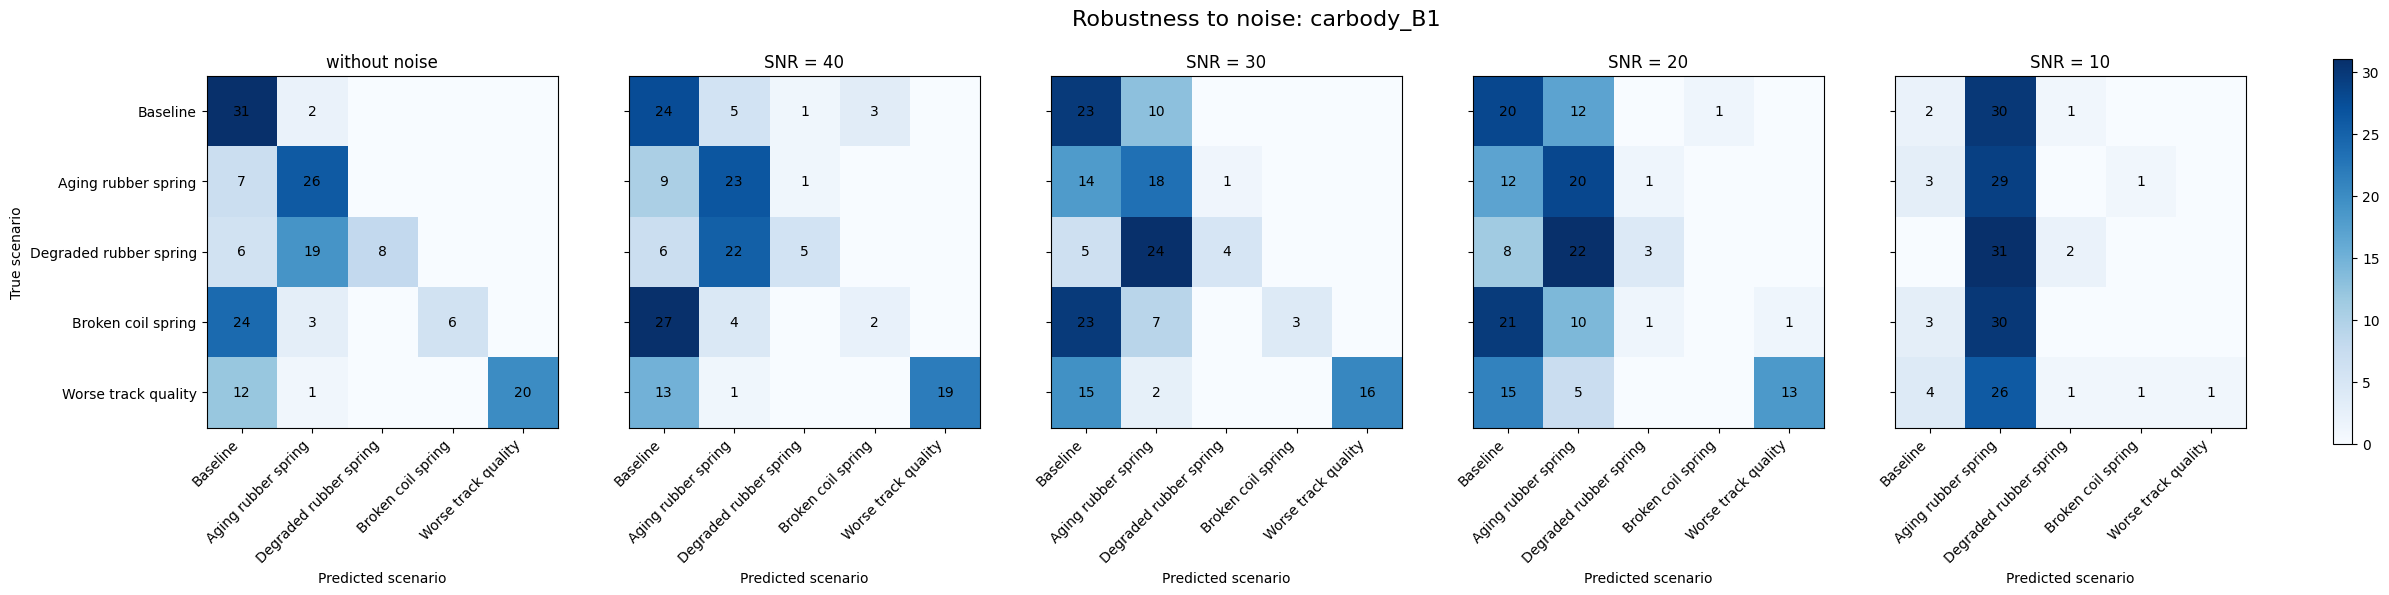

In [88]:
conf_mat_noise(sensor_names[0], confusion_dict_noise)

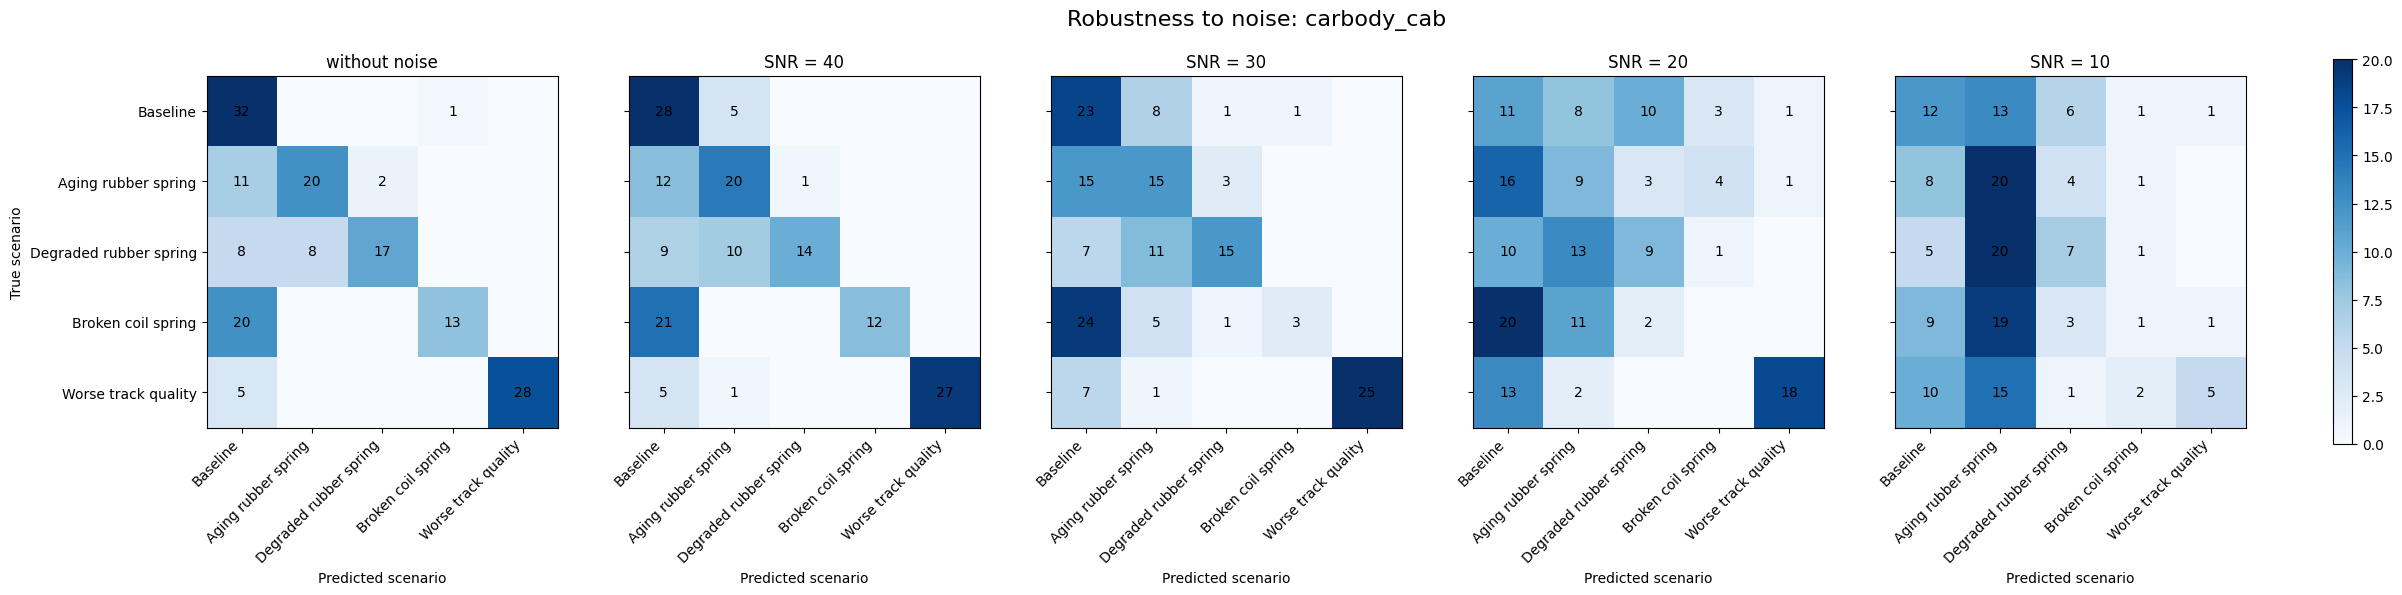

In [91]:
conf_mat_noise(sensor_names[1], confusion_dict_noise)

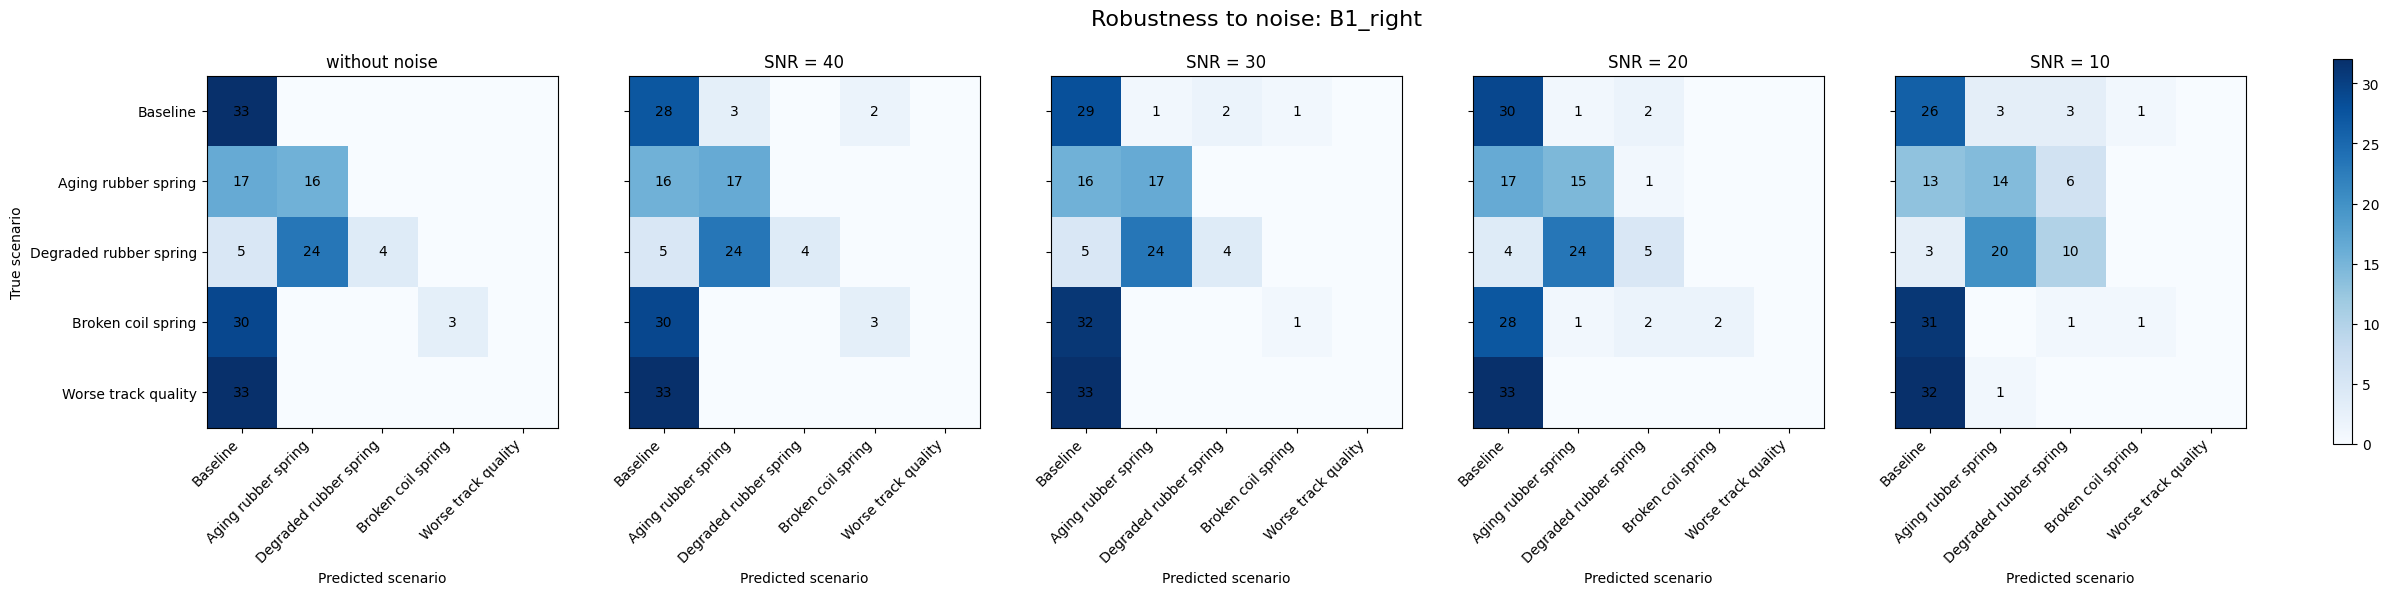

In [92]:
conf_mat_noise(sensor_names[2], confusion_dict_noise)

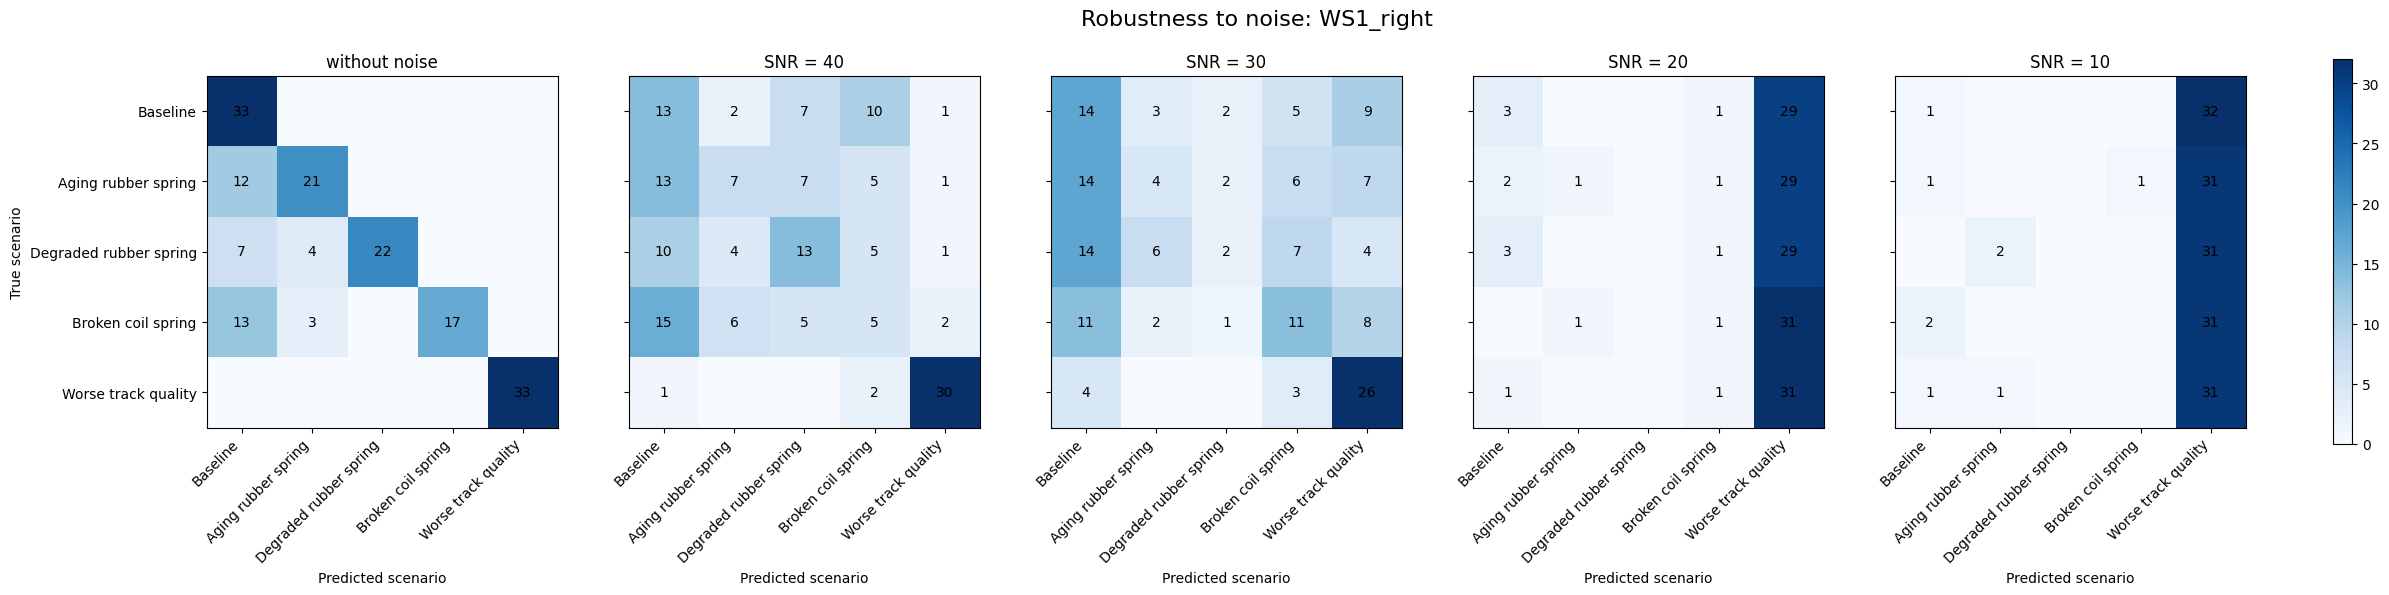

In [93]:
conf_mat_noise(sensor_names[3], confusion_dict_noise)

segment found


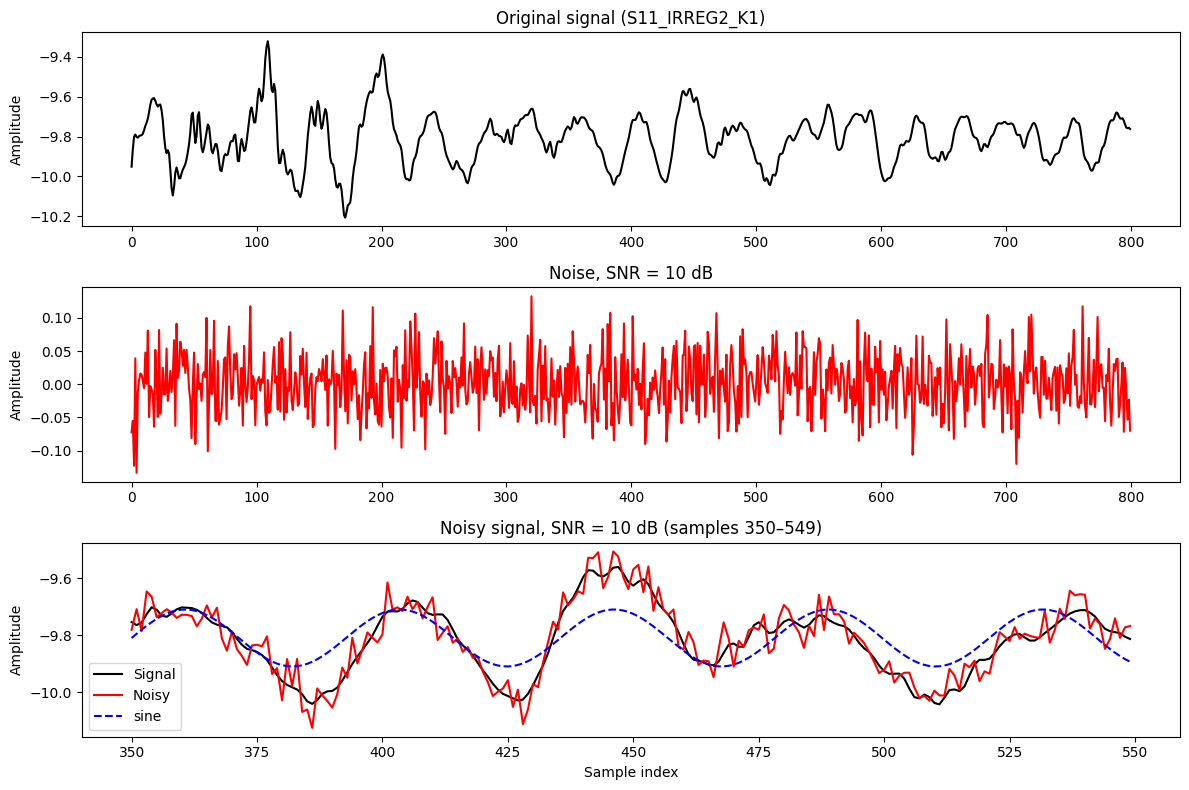

In [133]:
sensor_name = sensor_names[0]
snr = 10
target_scenario = scenarios[4]  # max. 4
target_seg_idx = 27  # max. 65, only odd


for true_scenario, sensor, seg_idx in test_segments:
    if (sensor == sensor_name and
        seg_idx == target_seg_idx and
        true_scenario == target_scenario):
        print("segment found")
        seg_signal, seg_start_time = raw_signals_by_segment[(true_scenario, sensor, seg_idx)]
        break

rng = np.random.default_rng()
seg_signal_mean = seg_signal - np.mean(seg_signal)
sig_power = np.mean(seg_signal_mean**2)
noise_power = sig_power / (10**(snr / 10.0))
noise = rng.normal(scale=np.sqrt(noise_power), size=seg_signal.shape)

noisy_sig = seg_signal + noise

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot the original signal on top
axes[0].plot(seg_signal, color="black")
axes[0].set_title(f"Original signal ({true_scenario})")
axes[0].set_ylabel("Amplitude")

# Plot noise
axes[1].plot(noise, color="red")
axes[1].set_title(f"Noise, SNR = {snr} dB")
axes[1].set_ylabel("Amplitude")

# Plot noisy signal segment
start = 350           # first sample to show
length = 200           # number of samples to show
end = start + length  # 250
x = 0.1*np.sin(2*np.pi*1.17*(np.arange(length)/50))-9.81

axes[2].plot(range(start, end), seg_signal[start:end], color="black", label="Signal")
axes[2].plot(range(start, end), noisy_sig[start:end], color="red", label="Noisy")
axes[2].plot(range(start, end), x, color="blue", linestyle="--", label="sine")
axes[2].set_title(f"Noisy signal, SNR = {snr} dB (samples {start}–{end-1})")
axes[2].set_ylabel("Amplitude")
axes[2].legend()

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()

In [ ]:
# to do: check new frequency content and peaks of a frame, play with frequency band weighing
# sampling rate probably not high enough for the axlebox sensor